In [1]:
import cv2
import numpy as np
import pandas as pd

# 입력 영상 경로
video_path = 'C:/Users/OSY\optical flow approximation/data/japan2.mp4'

# 비디오 캡처 초기화
cap = cv2.VideoCapture(video_path)

# 이전 프레임 초기화
ret, prev_frame = cap.read()
if not ret:
    exit(1)

# 데이터프레임을 위한 리스트 초기화
df_data = []

# 초당 10프레임으로 샘플링하기 위한 변수
frame_count = 0
frame_sample_rate = int(cap.get(cv2.CAP_PROP_FPS) / 10)

while True:
    # 다음 프레임 읽기
    ret, frame = cap.read()
    if not ret:
        break

    # 현재 프레임과 이전 프레임 사이의 차이 계산
    frame_diff = cv2.absdiff(frame, prev_frame)

    # 차이 이미지 이진화
    _, binary_diff = cv2.threshold(cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY), 30, 255, cv2.THRESH_BINARY)

    # 움직임 영역 추출
    contours, _ = cv2.findContours(binary_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 움직임 영역만 그리기 위한 복사본 생성
    movement_area = frame.copy()

    # 추출된 움직임 영역을 시각화 이미지에 그리기
    cv2.drawContours(movement_area, contours, -1, (0, 255, 0), 2)

    # 초당 10프레임으로 데이터 샘플링
    if frame_count % frame_sample_rate == 0:
        # 움직임 정보 계산
        movement_count = len(contours)
        if movement_count > 0:
            total_movement = 0
            centroid_x_sum = 0
            centroid_y_sum = 0
            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area > 0:
                    M = cv2.moments(cnt)
                    centroid_x_sum += int(M['m10'] / M['m00'])
                    centroid_y_sum += int(M['m01'] / M['m00'])
                    total_movement += area

            average_movement = total_movement / movement_count

            # 움직임 방향 계산
            average_centroid_x = centroid_x_sum / movement_count
            average_centroid_y = centroid_y_sum / movement_count
            average_movement_direction = np.arctan2(average_centroid_y - frame.shape[0] / 2,
                                                    average_centroid_x - frame.shape[1] / 2) * 180 / np.pi

            # 데이터프레임에 정보 추가
            df_data.append({
                'Time': cap.get(cv2.CAP_PROP_POS_MSEC) / 1000,  # 초 단위로 변환
                'Average Movement': average_movement,
                'Average Movement Size': np.sqrt(average_movement),
                'Average Movement Direction': average_movement_direction
            })

    # 시각화된 프레임 출력
    cv2.imshow("Crowd Flow Visualization", movement_area)

    # 이전 프레임 업데이트
    prev_frame = frame.copy()

    # 프레임 카운트 증가
    frame_count += 1

    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 데이터프레임 생성
df = pd.DataFrame(df_data)

# 데이터프레임 저장
df.to_csv('C:/Users/OSY\optical flow approximation/movementdata/japan2.csv', index=False)

# 자원 해제
cap.release()
cv2.destroyAllWindows()


In [2]:
df

,Time,Average Movement,Average Movement Size,Average Movement Direction
0,0.033333,9.354497,3.058512,-162.599927
1,0.133333,3.468250,1.862324,-152.864689
2,0.233333,8.860123,2.976596,-157.102718
3,0.333333,22.519685,4.745491,-156.027050
4,0.433333,12.005208,3.464853,-157.332974
...,...,...,...,...
2340,287.133333,4.808206,2.192762,-158.288788
2341,287.333333,5.686090,2.384552,-158.821901
2342,0.000000,4.970852,2.229541,-157.420039
2343,0.000000,4.000000,2.000000,-144.936390


In [3]:
import matplotlib.pyplot as plt

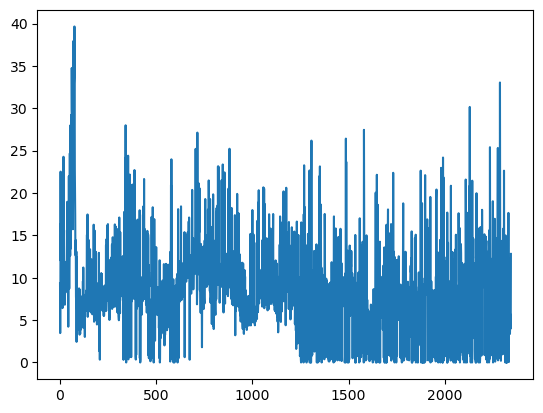

In [4]:
plt.plot(df['Average Movement'])

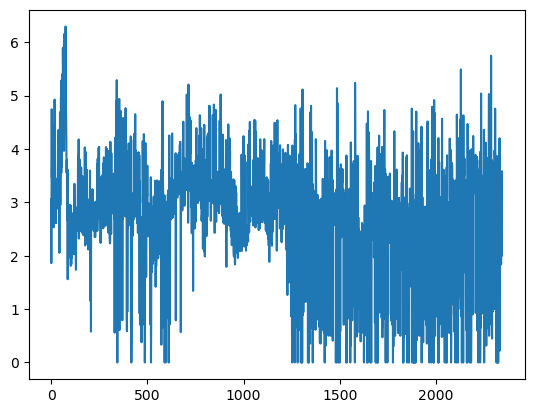

In [5]:
plt.plot(df['Average Movement Size'])

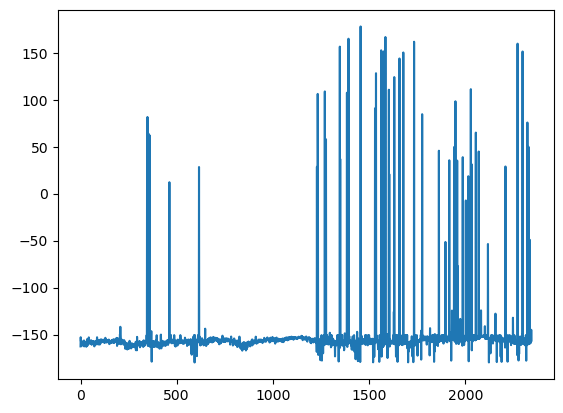

In [6]:
plt.plot(df['Average Movement Direction'])